# Values, Wikipedia, and the Pandemic: A Cross-national Descriptive Analysis


## Submission for Fundamentals of Social Data Science at the Oxford Internet Institute

# Part 1

## Introduction

The COVID-19 pandemic has revealed the fragility of the human body against an invisible force of nature, the SARS-CoV-2 virus. More so than our physical limitations, the resulting pandemic from the virus has revealed the diversity, strength, and weaknesses of social systems around the globe as countries struggle to cope while others begin to return to some normalcy. The abruptness of the pandemic meant governments had to respond swiftly withs scarce information and few precedents to rely upon. Citizens of nations also face many uncertainties as information trickles down from officials, livelihoods become threatened as economic activities shut down, and regulations change regularly (Dunn et al., 2020). In an environment of scientific, economic, and political uncertainties, governments and individuals must continue to make daily decisions that implicate individual livelihoods and collective success in managing the pandemic. 

Without medical treatment and vaccinations against this novel virus, non-pharmaceutical interventions, such as internal restrictions or mask-wearing mandates, through public policies are the only tool available to manage the pandemic(Cowling et al., 2020). The stringency and timeliness of policy interventions found in different countries also have a direct impact on the management of the pandemic (Cowling et al., 2020; Hale et al., 2020). Given the non-pharmaceutical measures’ demonstrated efficacy, why do countries still vary vastly in their policies?

Policymaking is often a balance of conflicting values and the policymaker’s role is finding such fulcrum (Thacher & Rein, 2004). The values which underly a society, therefore, has a significant role in the implementation of policies and may explain the variety of policies. Furthermore, public policies require public engagement to be effective and the subjects of policies also are motivated by a set of values. To illustrate this relationship, we can look at the example of lockdown policies. At the policy level, a lockdown can be viewed as a balance of economic importance against public health. For individuals, compliance with lockdown may be a balance between trust in the government and personal choice. Accordingly, we may expect there to be a relationship between a society’s values and the efficacy of its pandemic strategies.

Core values are stable traits within a society, meaning they do not fluctuate sporadically as preferences or attitudes do when faced with exogenous events (Inglehart, 1977; Uslaner, 2002). These values are often instilled during early upbringings and become embedded within individuals of a society. A measure of value change since the pandemic has found that values mostly remained stable(Reeskens et al., 2020). I hypothesize that core values may be an influential factor in the severity of the pandemic within a society because of policy decisions and individual compliance. To that end, this research seeks to identify and measure the extent to which societal values may influence the outcome of the pandemic.

Given the stability of values, this analysis will use the responses from the World Value Survey (WVS) ending in the years 2010, 2014, and 2009.  The date of the years was chosen to maximize the number of countries included. The validity of using older survey result is grounded in the theoretical stability of values. WVS results are aggregated at the country level because cultural values at the national level is a meaningful and distinct concept (Minkov & Hofstede, 2012). As a response variable, confirmed case counts will be used to measure the social compliance of policies as viral transmissions are often a result of close contacts with others.


## Data Analysis


### Set up

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
import altair as alt
import geopandas as gpd
import psycopg2
import adjustText

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import get_path_collection_extents

from itertools import product
from operator import itemgetter

from math import floor
from scipy import stats
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [3]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

### Wrangling

In [4]:
class CovidWVS():
    def __init__(self):
        self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        self.world.loc[self.world.name == 'France', 'iso_a3'] = 'FRA' # France is missing its ISO country code

        self.survey_sql_command = f"""SELECT left(s.wave, 4) AS start_year,
                                             right(s.wave, 4) AS end_year,
                                             s.gid, s.countrycode, s.country, s.samplesize, s.properties 
                                        FROM surveys s
                                        WHERE (s.gid, right(s.wave, 4)) IN (
                                              SELECT gid, max(right(wave, 4)) AS end_year
                                              FROM surveys s2 
                                              GROUP BY s2.gid) AND

                                              adm_area_1 ISNULL
                                              ORDER BY country asc"""

        self.epidm_sql = """select e.gid, 
                                   e.country, 
                                   e.countrycode, 
                                   e.date, 
                                   wb.value,
                                   e.confirmed, 
                                   e.dead, 
                                   round(cast((cast(e.dead as float)/cast(e.confirmed as float)*100.0) as numeric), 2) as death_rate,
                                   round((cast(e.confirmed as float)/(cast(wb.value as integer))*100000)) as cases_per_100k
                            from
                                   epidemiology e
                            join
                                   world_bank wb 
                            on 
                                   e.countrycode = wb.countrycode and
                                   COALESCE(e.adm_area_1, '') = COALESCE(wb.adm_area_1, '') and
                                   COALESCE(e.adm_area_2, '') = COALESCE(wb.adm_area_2, '') and
                                   COALESCE(e.adm_area_3, '') = COALESCE(wb.adm_area_3, '')
                             where
                                   wb.indicator_code like 'SP.POP.TOTL' and
                                   e.date = '2020-12-01' AND
                                   e.adm_area_1 isnull and
                                   e.source = 'WRD_ECDC'
                            order by country"""

        self.epidm_df = pd.read_sql(self.epidm_sql, conn)
        self.epidm_df = self.epidm_df.set_index(self.epidm_df['countrycode'])

        self.survey_df = pd.read_sql(self.survey_sql_command, conn)
        self.survey_df = pd.merge_ordered(self.survey_df, self.world[['iso_a3', 'continent', 'gdp_md_est', 'pop_est', 'geometry']], right_on='iso_a3', left_on='countrycode', how='left')
        self.survey_df = self.survey_df.dropna(how='any')
        self.survey_df = self.survey_df.drop(columns=['gid', 'iso_a3'], errors='ignore')
        self.survey_df = self.survey_df[self.survey_df['end_year'].astype(int) >= 2009]
        self.survey_df.reset_index(drop=True, inplace=True)
        
        
    @staticmethod
    def getCountryMode(row, question_label):
        '''
        For a given record in survey_df, generate the mode
        '''
        result_df = pd.read_json(json.dumps(row.properties), orient='index')
        if question_label in result_df['Frequencies']:
            q_results = result_df.loc[question_label] #(Series of dict)
            q_labels = q_results['Categories'] # dict
            q_freqs = q_results['Frequencies'] #dict

            mode = 0
            mode_key = None

            for k, v in q_freqs.items():
                if v > mode and not k[-2] == '-':
                    mode = v
                    mode_key = k
                else:
                    continue

            label_key = re.search("\d{1,5}$", mode_key).group()
            return pd.Series([q_labels[label_key], mode], index=[f"{question_label}_mode_label", f"{question_label}_mode"])
    
    
    def getSurveyMode(self, question_label):
        copy = self.survey_df.copy()
        final_df = copy.join(copy.apply(self.getCountryMode, axis=1, args=[question_label]), how='left')
        return final_df

    @staticmethod
    def rowTransform(row, country, q, invalids):
        result_df = pd.read_json(json.dumps(row.properties), orient='index')

        categories = result_df.loc[q]['Categories']
        frequencies = result_df.loc[q]['Frequencies']
        sample_size = row['samplesize']
        invalid_samples = 0

        combined_dict = {}
        for k in categories:
            if f"{q}_{k}" in frequencies:
                counts = round(frequencies[f"{q}_{k}"]*sample_size)
                domain = categories[k]
                if not invalids is None and domain in invalids:
                    invalid_samples += counts
                combined_dict[domain] = counts
            else:
                pass

        combined_dict.update({'samplesize':sample_size,
                              'valid_samplesize':(sample_size-invalid_samples),
                              'invalid_samplesize':invalid_samples})

        return {country: combined_dict}
    
    
    def transformResults(self, q, valids=None, invalids=None, full_df=False):
        """
        returns the porportion of valid responses and invalid response counts. The reasoning behind this function is that
        reponses such as "Don't know" or "No Answers" do not have a concrete interpretation and thus should be removed from the porportions
        provided by the WVS.

        parameters:
            q (str): WVS label
            valids (list of Str): Response/domain names that are valid and have an interpretation
            invalids (list of Str or None): Responses that are invalid and should be removed from the porportion calculation. If None,
                                            the function returns the raw dataframe. Supercedes full_df.
            full_df (bool): 
                True - return the full DataFrame containing invalid sample counts and sample sizes
                False - return just the valid sample porportions normalized to just the valid responses

        returns:
            DataFrame: A dataframe with only the valid responses' porportions calculated
        """
        df = self.survey_df
        country_dict = {}
        transform_series = df.apply(lambda row: self.rowTransform(row, row['countrycode'], q, invalids), axis=1)
        for record in transform_series:
            country_dict.update(record)
        final_df = pd.DataFrame.from_dict(country_dict, orient='index')
        
        if valids is None:
            return final_df
        else:
            final_df[valids] = final_df[valids].div(final_df['valid_samplesize'].values, axis=0)

            if full_df:
                return final_df
            else:
                return final_df[valids]

    
    def getSummatedRating(self,
                          q, 
                          domains=['Not at all important', 'Not very important', 'Rather important', 'Very important'],
                          weights=[1,2,3,4],
                          invalids=[],
                          col_name='value'):
        '''
        returns the summated rating for valid Likert item responses. Valid responses are determined through domains.
        '''
        df = self.survey_df
        country_vals_df = self.transformResults(q, valids=domains, invalids=invalids, full_df=False)
        melted_df = pd.melt(country_vals_df.reset_index(), id_vars=['index'], value_vars=domains)
        melted_df.columns = ['countrycode', 'rating', 'value']
        weight_dict = dict(zip(domains, weights))
        melted_df['partial_weight'] = melted_df.apply(lambda row: row['value']*weight_dict[row['rating']], axis=1)
        
        summated_rating = round(melted_df[['countrycode', 'partial_weight']].groupby(by='countrycode').sum(), 2)
        summated_rating.columns = [col_name]
        
        return summated_rating
    

    def plotScatterValueEpidm(self, 
                              q, 
                              domains, 
                              weights,
                              invalids,
                              title,
                              labels=False,
                              plot='cases_per_100k', 
                              x_label='Social Value', 
                              y_label='Cases per 100,000 population', 
                             ax=None):
        
        summed_rating = self.getSummatedRating(q, domains, weights, invalids)
        df = (self.epidm_df[['death_rate', 'cases_per_100k', 'confirmed']]
                  .join(summed_rating[summed_rating.value > 0]))
        
        df = df.merge(self.survey_df[['continent', 'country', 'countrycode']], on='countrycode', how='left').dropna(how='any')
        n = len(df)

        spearmanr = stats.spearmanr(df['value'], df[plot])
        r = round(spearmanr[0], 2)
        p = round(spearmanr[1], 3)

        annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':10}}

        plt.figure(figsize=(10, 10), dpi=100)
        ax = sns.scatterplot(data=df, x='value', y=plot, hue='continent', ax=ax)
        plt.text(0.5,0.01, "Spearman's Rho={:f}, p={:f}".format(r,p),
                 ha='center', verticalalignment='bottom', fontweight='bold', transform=ax.transAxes)
        ax.set(xlabel=x_label, ylabel=y_label, title=title+f" (n={n})")
        ax.legend(loc='best', **annot_kws)
#         print("Spearman's Rho={:f}, p={:f}".format(r,p))
        
        if labels:
            texts = []
            for i, txt in enumerate(df.countrycode):
                texts.append(plt.text(df.iloc[i]['value']+0.004, df.iloc[i][plot], txt, 
                                      horizontalalignment='left', size='medium', color='black'))
            adjust_text(texts)
        return plt
    
    def getLabelName(self, q):
        result_df = pd.read_json(json.dumps(self.survey_df.iloc[0].properties), orient='index')
        return result_df.loc[q]['Label']
    
    def subplotScatterValueEpidm(self, 
                              q, 
                              domains, 
                              weights,
                              invalids,
                              title,
                              labels=False,
                              plot='cases_per_100k', 
                              x_label='Social Value', 
                              y_label='Cases per 100,000 population', 
                             ax=None):
        
        summed_rating = self.getSummatedRating( q, domains, weights, invalids)
        df = (self.epidm_df[['death_rate', 'cases_per_100k', 'confirmed']]
                  .join(summed_rating[summed_rating.value > 0]))
        
        df = df.merge(self.survey_df[['continent', 'country', 'countrycode']], on='countrycode', how='left').dropna(how='any')
        n = len(df)

        spearmanr = stats.spearmanr(df['value'], df[plot])
        r = round(spearmanr[0], 2)
        p = round(spearmanr[1], 3)

        annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':10}}

        plt.figure(figsize=(10, 10))
        ax = sns.scatterplot(data=df, x='value', y=plot, ax=ax, legend=False)
        ax.set(xlabel=x_label, ylabel=y_label, title=title+f" (n={n})")
        
        if labels:
            texts = []
            for i, txt in enumerate(df.countrycode):
                texts.append(plt.text(df.iloc[i]['value']+0.004, df.iloc[i][plot], txt, 
                                      horizontalalignment='left', size='medium', color='black'))
            adjust_text(texts)
        return [plt, r, p]
    
    def getLabelName(self, q):
        result_df = pd.read_json(json.dumps(self.survey_df.iloc[0].properties), orient='index')
        return result_df.loc[q]['Label']        
        
pt1 = CovidWVS()

In [5]:
invalids = ['Don´t know', "Don't know", 'No answer','Not asked in survey','Missing; Unknown','samplesize','valid_samplesize','invalid_samplesize', 'Not applicable',np.nan, None]
interested = ['A001', 'A002', 'A005', 'A165', 'A173', 'A192', 'A196', 'A199', 'E018', 'E037', 'E069_04', 'E069_08', 'E069_10', 'E069_11', 'E069_20', 'E069_54', 'E115', 'E117', 'E217', 'E235', 'X025']

domain_dict = {}
for q in interested:
    domain_dict.update({q:pt1.transformResults(q).columns.tolist()})

domain_df = pd.DataFrame.from_dict(domain_dict, orient='index')

In [6]:
pd.set_option('display.max_colwidth', 0)


def getAllSummated(q_list, col_names, invalids=invalids):
    sum_df = pd.DataFrame([],index=pt1.survey_df.countrycode)
    for i, q in enumerate(q_list):            
        domains = [domain for domain in domain_df.loc[q].to_list() if not domain in invalids]
        max_score = len(domains)
        if max_score==2:
            weights=[2,1]
        if max_score== 4:
            weights=[4,3,2,1]
        elif max_score == 6:
            weights=[6,5,4,3,2,1]
        elif max_score == 10:
            weights = [1,2,3,4,5,6,7,8,9,10]
        elif q == "X025":
            weights = [2,3,4,5,6,7,8,9,1]
        
        if col_names == 'label':
            col = q
        else:
            col = col_names[i]
        sum_rating = pt1.getSummatedRating(q,
                                           domains=domains,
                                           weights=weights,
                                           invalids=invalids,
                                           col_name=col)
        sum_df = sum_df.join(sum_rating)
        
    return sum_df

sum_df = getAllSummated(interested, col_names='label')

tbl_1_dict = {}
for q in interested:
    valids = [domain for domain in domain_df.loc[q].to_list() if not domain in invalids]
    tbl_1_dict.update({q: [pt1.getLabelName(q), valids]})
tbl_1 = pd.DataFrame.from_dict(tbl_1_dict, orient='index', columns=['Question title', 'Valid responses'])
tbl_1['Full score'] = tbl_1['Valid responses'].str.len()
tbl_1 = tbl_1.join(sum_df.describe().loc[['count', '50%', 'std']].T)
tbl_1.columns = ['Question title', 'Valid responses', 'Full Score', 'n', 'Median', 'Std Dev.']

display(tbl_1.sort_index())
print('Table 1.1. Summary statistics and response ranges of interested WVS questions.')

,Question title,Valid responses,Full Score,n,Median,Std Dev.
A001,Important in life: Family,"[Very important, Rather important, Not very important, Not at all important]",4,93.0,3.90,0.086346
A002,Important in life: Friends,"[Very important, Rather important, Not very important, Not at all important]",4,93.0,3.36,0.197091
A005,Important in life: Work,"[Very important, Rather important, Not very important, Not at all important]",4,93.0,3.51,0.218923
A165,Most people can be trusted,"[Most people can be trusted, Can´t be too careful]",2,93.0,1.21,0.160746
A173,How much freedom of choice and control,"[None at all, 2, 3, 4, 5, 6, 7, 8, 9, A great deal]",10,93.0,7.01,0.651955
A192,Schwartz: It is important to this person to have a good time,"[Very much like me, Like me, Somewhat like me, A little like me, Not like me, Not at all like me]",6,93.0,3.36,1.802025
A196,Schwartz: It is important to this person to always behave properly,"[Very much like me, Like me, Somewhat like me, A little like me, Not like me, Not at all like me]",6,93.0,4.30,2.086175
A199,Schwartz: It is important to this person to do something for the good of society,"[Very much like me, Like me, Somewhat like me, A little like me, Not like me, Not at all like me]",6,93.0,4.12,2.271148
E018,Future changes: Greater respect for authority,"[Good thing, Don´t mind, Bad thing]",3,93.0,5.54,0.300100
E037,Government responsibility,"[People should take more responsibility, 2, 3, 4, 5, 6, 7, 8, 9, The government should take more responsibility]",10,93.0,5.82,1.151253


Table 1.1. Summary statistics and response ranges of interested WVS questions.


## Outputs and Visualizations

Text(0.5, 1.0, 'Fig 1.1. Spearman rank correlation heatmap of all potentially interesting values from the WVS')

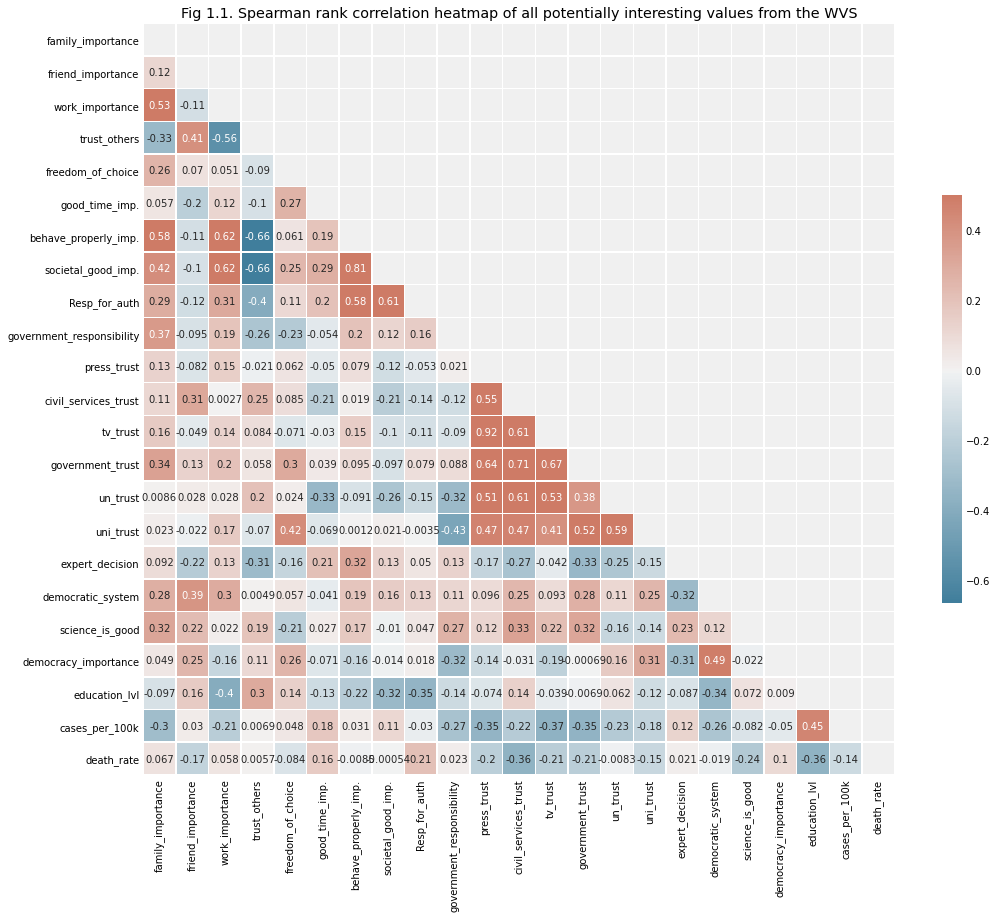

In [7]:
my_col_names = ['family_importance', 'friend_importance', 'work_importance', 'trust_others', 
                'freedom_of_choice', 'good_time_imp.', 'behave_properly_imp.', 'societal_good_imp.', 
                'Resp_for_auth', 'government_responsibility', 'press_trust', 'civil_services_trust', 
                'tv_trust', 'government_trust', 'un_trust', 'uni_trust', 'expert_decision', 
                'democratic_system', 'science_is_good', 'democracy_importance', 'education_lvl']

sum_df = getAllSummated(interested, col_names=my_col_names)
sum_df.replace(0, np.nan, inplace=True)
sum_df = sum_df.join(pt1.survey_df[['continent', 'countrycode']].set_index('countrycode'), how='left')
epidm_sum_df = sum_df.join(pt1.epidm_df[['cases_per_100k', 'death_rate', 'countrycode']].set_index('countrycode'))

# Correlation heatmap code from Seaborn example.

corr = epidm_sum_df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("Fig 1.1. Spearman rank correlation heatmap of all potentially interesting values from the WVS")

In [8]:
corr[abs(corr.cases_per_100k) >= 0.3].index.to_list()

['family_importance',
 'press_trust',
 'tv_trust',
 'government_trust',
 'education_lvl',
 'cases_per_100k']

Text(0.5, 1.01, 'Fig 1.2. A pair plot of relationships between the interested values from the WVS.')

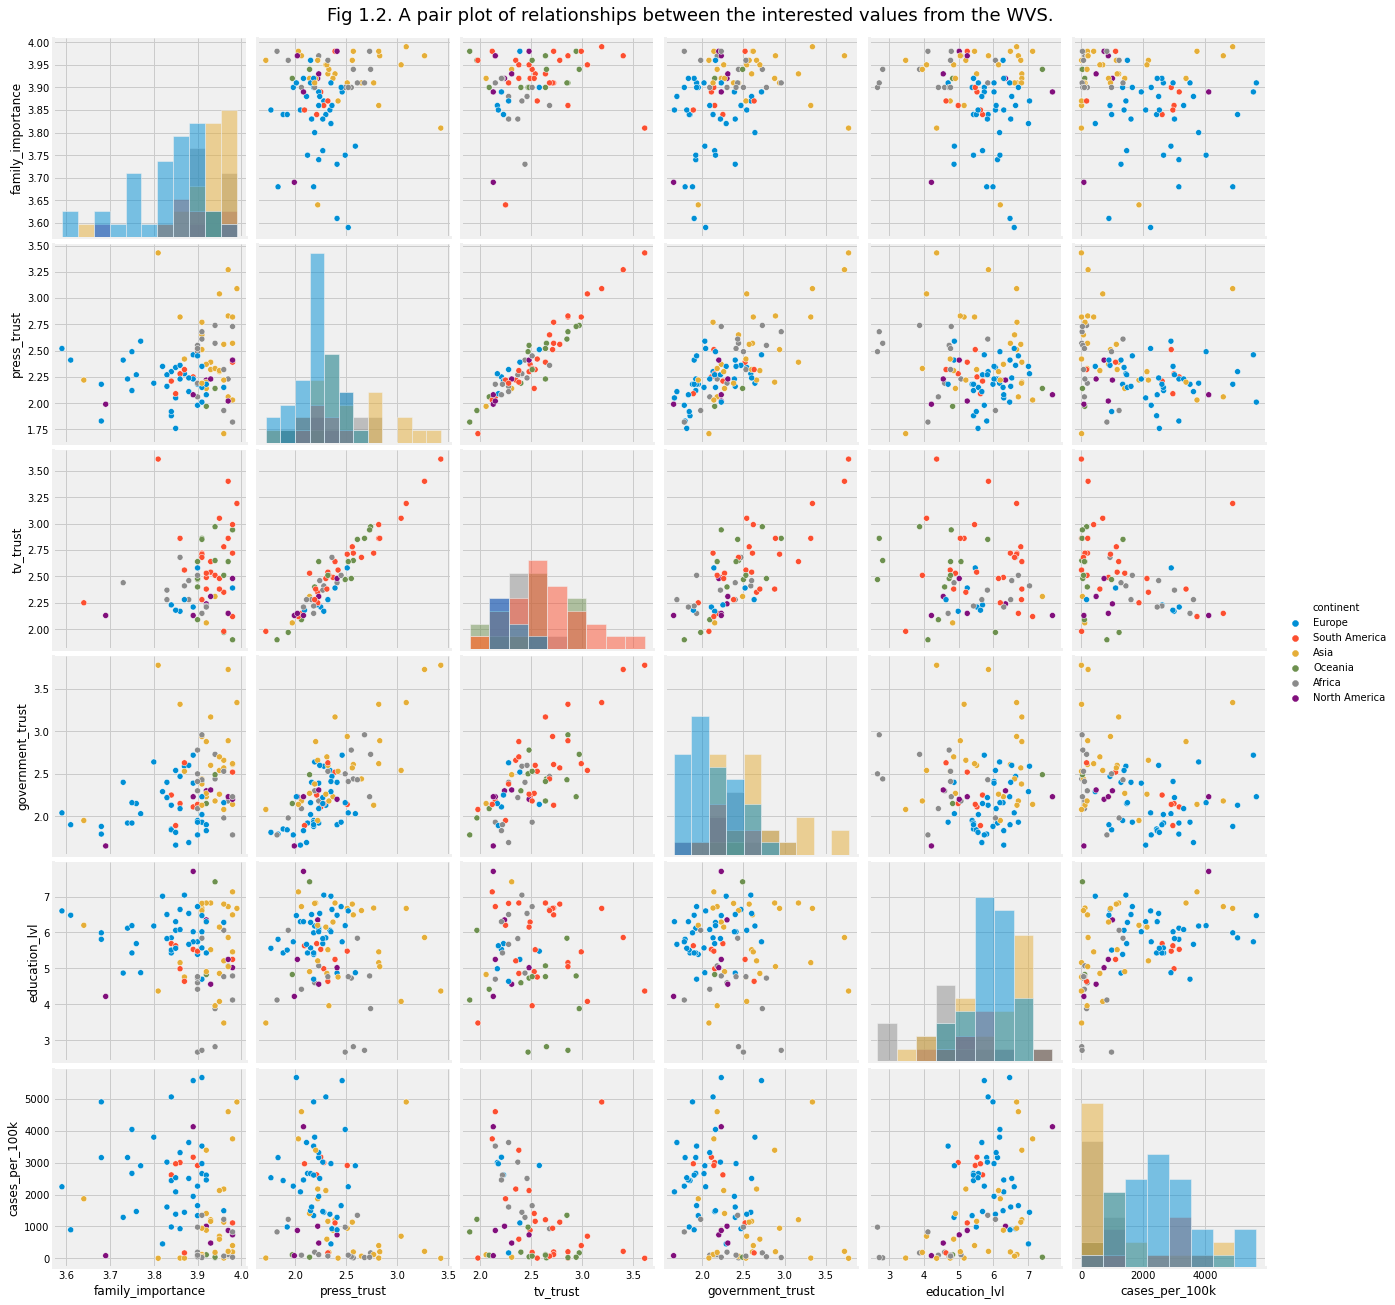

In [9]:
final_interested = corr[abs(corr.cases_per_100k) >= 0.3].index.to_list()
final_interested.append('continent')
interested_df = epidm_sum_df[final_interested].copy()
g = sns.pairplot(interested_df, hue='continent', height=3, diag_kind='hist', dropna=True)
g.fig.suptitle('Fig 1.2. A pair plot of relationships between the interested values from the WVS.', y=1.01, fontsize=18)

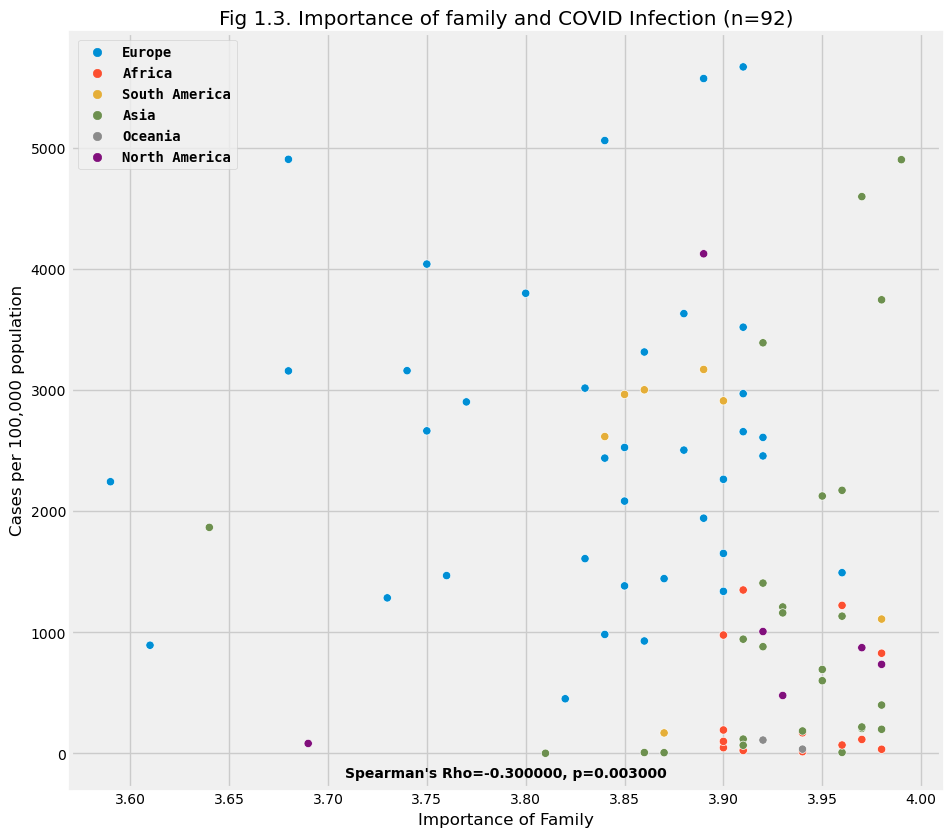

In [10]:
q = 'A001'
domains = [domain for domain in domain_df.loc[q].to_list() if not domain in invalids]
fig3 = pt1.plotScatterValueEpidm(q,
                                 domains=domains,
                                 weights=[4,3,2,1],
                                 plot='cases_per_100k',
                                 invalids=invalids,
                                 labels=False,
                                 title='Fig 1.3. Importance of family and COVID Infection',
                                 x_label='Importance of Family',
                                 y_label="Cases per 100,000 population")

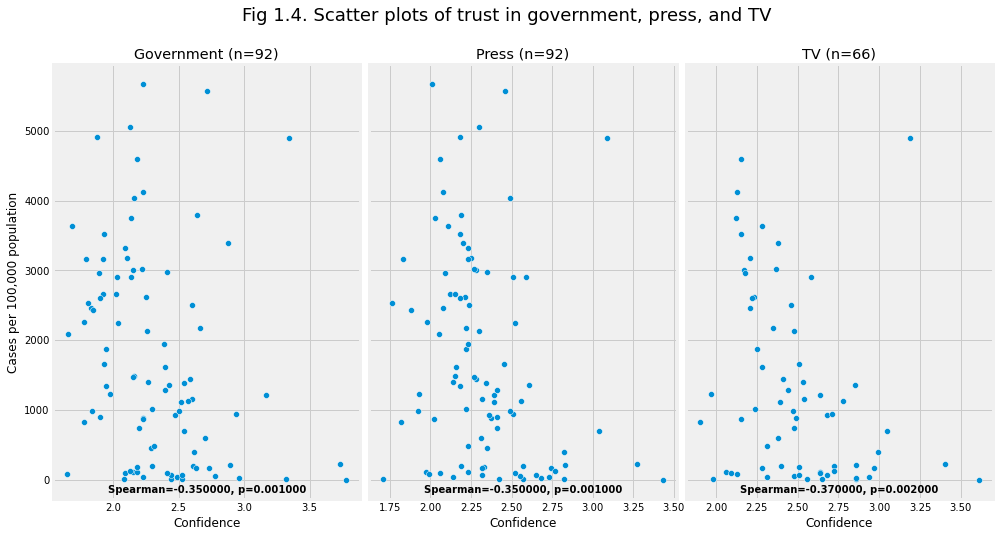

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [11]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

fig.suptitle('Fig 1.4. Scatter plots of trust in government, press, and TV', fontsize=18)

domains = [domain for domain in domain_df.loc['E069_11'].to_list() if not domain in invalids]
ax1 = pt1.subplotScatterValueEpidm('E069_11',
                                 domains=domains,
                                 weights=[4,3,2,1],
                                 plot='cases_per_100k',
                                 invalids=invalids,
                                 labels=False,
                                 title='Government',
                                 x_label='Confidence',
                                 y_label="Cases per 100,000 population",
                         ax=axs[0])
axs[0].text(0.5,0.01, "Spearman={:f}, p={:f}".format(ax1[1],ax1[2]),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=axs[0].transAxes)

ax2 = pt1.subplotScatterValueEpidm('E069_04',
                                 domains=domains,
                                 weights=[4,3,2,1],
                                 plot='cases_per_100k',
                                 invalids=invalids,
                                 labels=False,
                                 title='Press',
                                 x_label='Confidence',
                                 y_label="Cases per 100,000 population",
                         ax=axs[1])
axs[1].text(0.5,0.01, "Spearman={:f}, p={:f}".format(ax2[1],ax2[2]),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=axs[1].transAxes)

ax3 = pt1.subplotScatterValueEpidm('E069_10',
                                 domains=domains,
                                 weights=[4,3,2,1],
                                 plot='cases_per_100k',
                                 invalids=invalids,
                                 labels=False,
                                 title='TV',
                                 x_label='Confidence',
                                 y_label="Cases per 100,000 population",
                         ax=axs[2])
axs[2].text(0.5,0.01, "Spearman={:f}, p={:f}".format(ax3[1],ax3[2]),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=axs[2].transAxes)

fig.subplots_adjust(wspace=0.03, hspace=0.1)

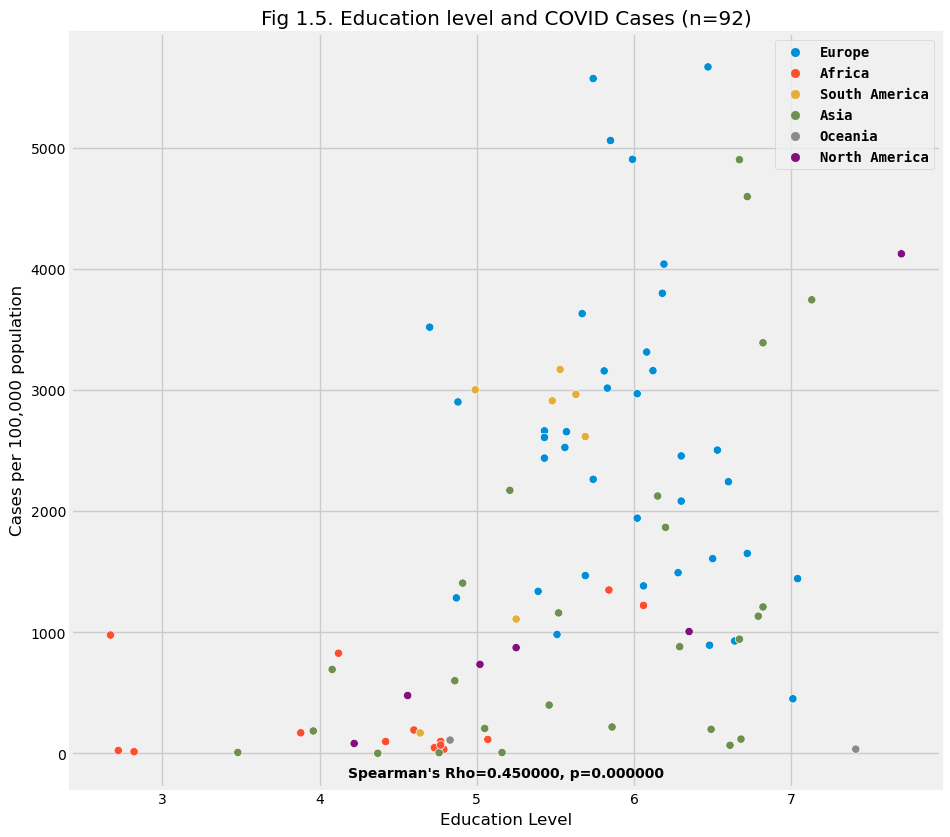

In [12]:
q = 'X025'
domains = [domain for domain in domain_df.loc[q].to_list() if not domain in invalids]

fig5 = pt1.plotScatterValueEpidm(q,
                                 domains=domains,
                                 weights=[2,3,4,5,6,7,8,9,1],
                                 plot='cases_per_100k',
                                 invalids=invalids,
                                 labels=False,
                                 title='Fig 1.5. Education level and COVID Cases',
                                 x_label='Education Level',
                                 y_label="Cases per 100,000 population")

## Discussion

The analysis began with 21 potentially interesting questions from the WVS (Table 1.1). These questions were selected due to their potential to have a direct impact on the stringency of policies and individuals’ likelihood of complying with pandemic policies. The responses to the questions are Likert items with a range of 4 to 10 valid responses. Most responses did not have a neutrality point, and instead of inferring them on responses such as “don’t know” or “not applicable”, the data was adjusted to treat those as missing data. Each Likert item was assigned a value of between 1 to 10 depending on its scale with 1 being the most negative and 10 the most positive responses. The responses were summated into a Likert-scale score for analysis (Warmbrod, 2014).  

The relationship between the initial group of variables and the response variable showed that only a small subset had had a moderate monotonic relationship with the response variable of cases per 100,000 population (Fig 1.1). Out of the 21 potential variables and using a Spearman’s rank correlation of greater than 0.3, 5 variables of interests emerged. Most of the final variables were congruent with reasonable expectations except for one surprising finding. Also noteworthy is that no significantly impacted values emerged as the highest level of Spearman’s Rho was 0.45. This may, perhaps, indicate that values only have a weak to moderate effect on the pandemic.

The first variable of interest is the importance of family. Its summated score is highly consistent across the countries (stdev=0.09, n=92) and has the highest median out of all the initial variables (median=3.9). This is unsurprising as few countries are likely to embrace a culture of familial neglect. The distribution of family importance in Asia is higher than that of Europe (Fig 1.2). This is consistent with the Inglehart-Welzel Cultural Map which sees Asian countries expressing more survival values, values more closely related to ethnocentricity and physical security, than their European counterparts (Inglehart & Welzel, 2020). In figure 1.3, it is also interesting to note that Asian, African, and Oceanic countries clusters heavily on the bottom right corner, meaning high family importance and low cases, while European countries form a much broader spread across the ranges of the two variables further out on a plot from low family importance-low cases to high-family importance-high cases. When correlated with the response variable, a negative monotonic relationship was observed (Rho=-0.3, p<0.005). In countries that placed greater importance on family, one can expect to see relatively fewer cases per 100,00 population. This may mean that those countries’ citizens behave in a more pandemic safe manner because they do not want to endanger their family thus lowering transmission. 

The next set of variables of interest share a similar theme of trust. Trust of the press, government, and television may be categorized as institutional trust. Trust in the press and television have a normal distribution across most countries except for Europe’s TV trust. Europe had a lower TV trust distribution than all other continents with a right-skewed distribution (Fig 2). Similarly, European countries were observed to have less trust in the government than countries on the other continents. Inglehart and Welzel posit European countries tend to exhibit more self-expressionist values, such as demanding more involvement in politics, which could explain the lower levels of trust in government (2020). The three variables also demonstrate a high level of collinearity with each permutated combination having a Spearman’s rank correlation of greater than 0.6 and some exhibiting a strong linear correlation. The most significant of the collinearities is between television and press trust forming a clear linear pattern with a Spearman’s rank correlation of 0.92. The positive and moderately strong collinearities between the three variables entail countries trusting one institution is also likely to trust another. The weaker of the collinearities is government trust, which demonstrates more scepticism in general towards governments than press and televised media. 

Most noteworthy is the relationship between the trust variables and the response variable. All three trust variables have a statistically significant (p<0.005) moderate negative monotonic relationship with the number of COVID-19 cases, demonstrating that countries that place greater trust in these institutions tend to experience slightly fewer transmissions (Fig 4). Given the absence of readily available information to most individuals, a greater trust in the institutions may also translate to greater compliance and better pandemic outcome. Countries with less trust in the institution may be where fringe alternative theories, such as a disbelief in the virus or a conspiracy against freedom, flourish and hurt the pandemic responses. It is reasonable and comforting to see stable values such as institutional trusts have a possible correlation with the outcome of the pandemic.
The unexpected observation from this analysis is the relationship between education level and positive cases. Education level was the only variable with a near medium positive Spearman’s correlation (Spearman’s = 0.45, p<0.005). The distribution follows an exponential curve closely, with countries having higher average education levels reporting significantly more cases than less educated countries (Fig 5). African, Asian, and the countries are on the lower end of the scale with a less average education and fewer cases. Conversely, European countries generally had higher education levels and significantly more cases. There is no direct explanation or fitting theoretical backing for this phenomenon, however, this relationship may be a manifestation of undetected confounders. A likely confounder, I hypothesize, for this phenomenon is the days passed since the first case of COVID-19 (BBC, 2020). Developed nations, those in Europe and North America with a highly educated population, generally implemented lockdown measures days after the first reported case. In developing nations, those in Sub-Saharan Africa and South America, lockdowns were generally imposed at the time or after the report of the first case. With this hypothetical understanding, education level is unlikely to have a causal or meaningful relationship with the number of positive cases.


# Part 2

## Introduction

Perhaps best known for the warnings raised against its use, Wikipedia has defied its notoriety and thrived as a premier source of information today. On the internet, Wikipedia is the most accessed source for health information (Heilman & West, 2015) and it remains relevant in education and professional uses (Smith, 2020). The dynamic nature of Wikipedia’s contents and its collaborative environment positions it as an ideal source for aggregating new and emerging information. Wikipedia’s role of information aggregate is especially important in the current environment where new information emerges unpredictably and rapidly. 

Wikipedia has been the centre of interest for pandemic related studies in the past. In a similar style to the Google Flu Trend, Wikipedia activities were found to accurately estimate influenza-like illness levels (McIver & Brownstein, 2014) and various other diseases (Priedhorsky et al., 2017). In a recent study, a combination of Twitter, Google searches, and Wikipedia views provided a strong estimate for COVID-19 cases in the USA (O’Leary & Storey, 2020). These studies carried out “nowcasting” by using activity levels to predict real-world events (Salganik, 2017). There is, however, a gap within current literature that investigates the qualitative attributes of Wikipedia articles against real-world events.

The theory behind such a relationship is that higher quality and more in-depth articles may contribute to a more informed population. During the current health crisis, an informed population may have non-trivial impacts on the pandemics’ outcome. Research on the quality of articles dominates all Wikipedia research and a multitude of models and approaches have been proposed (Smith, 2020). To limit the scope of this analysis, the proxy for quality that will be chosen will be article length. Article length, measured by word counts, has been demonstrated as a significant predictor for quality (Blumenstock, 2008). To that end, using the word count of COVID-19 and public health articles in countries against select WVS values, country attributes, and epidemiology variable, I raise the questions:

> Does Wikipedia article quality, measured as a proxy of article length, have any predictive power for real-world measures? Conversely, does real-world qualities influence the quality of a Wikipedia article?


## Data Analysis

### Set up

In [13]:
import wikipedia
import spacy 
nlp = spacy.load('en_core_web_sm')

### Wrangling

In [14]:
def getWikiText(title, full_text=True, lower=True, clean=False):
    try:
        if full_text:
                page = wikipedia.page(title).content
        else:
            page = wikipedia.summary(title)
    except:
        page = None
        
    if page == None:
        return None
        
    if lower:
        page = page.lower()
    
    if clean:
        page = nlp(page)
        reduced = [token.lemma_.strip() for token in page if token.text.isalpha() == True]
        
        return " ".join(reduced)
    else:
        return page

In [15]:
health_status = pt1.getSummatedRating('A009', domains=['Very good', 'Good', 'Fair', 'Poor', 'Very poor'],
                     weights=[5,4,3,2,1],col_name='health_state').replace(0, np.nan).dropna()
med_freq = pt1.getSummatedRating('H008_03',
                     domains=['Often', 'Sometimes', 'Rarely', 'Never'],
                     weights=[1,2,3,4],
                     col_name='freq_without_med').replace(0, np.nan).dropna()
health_status = health_status.join(med_freq, how='left')
health_status = health_status.join(pt1.survey_df[['country', 'countrycode', 'pop_est', 'gdp_md_est', 'geometry']].set_index('countrycode'))
health_status['gdp_per_capita'] = health_status.apply(lambda x: x['gdp_md_est']/x['pop_est']*1000000, axis=1)

print("Getting first query...")
health_status['wiki_pub_health_clean'] = health_status.apply(lambda x: getWikiText(f"health in {x['country']}", clean=True), axis=1)
health_status['wiki_pub_health_length'] = health_status.wiki_pub_health_clean.str.len()

print("Getting second query...")
health_status['wiki_covid_clean'] = health_status.apply(lambda x: getWikiText(f"COVID-19 pandemic in {x['country']}", clean=True), axis=1)
health_status['wiki_covid_length'] = health_status.wiki_covid_clean.str.len()

Getting first query...
Getting second query...


In [16]:
health_status.to_csv('part2.csv')

In [17]:
health_status = pd.read_csv('part2.csv', index_col=0)

In [21]:
health_status = health_status.dropna()
health_status.loc[:, ['wiki_pub_health_length','wiki_covid_length']] = health_status[['wiki_pub_health_length','wiki_covid_length']].astype('int32')

### Outputs and Visualizations

In [23]:
health_status = health_status.join(pt1.epidm_df[['cases_per_100k', 'death_rate']])
health_wiki_df = health_status[['death_rate', 'cases_per_100k', 'health_state', 
                      'freq_without_med', 'gdp_per_capita', 'wiki_pub_health_length', 'wiki_covid_length']]

In [24]:
h1 = health_wiki_df['wiki_covid_length'].dropna()
h2 = health_wiki_df['wiki_pub_health_length'].dropna()

out_table_1 = pd.DataFrame([],columns=["n", "Mean","Std Dev."],
                           index=['wiki_covid_length', 'wiki_pub_health_length'])

out_table_1.loc['wiki_covid_length']= [len(h1), h1.mean(),h1.std()]
out_table_1.loc['wiki_pub_health_length']= [len(h2), h2.mean(),h2.std()]

display(out_table_1)
print("Table 2.1. Summary statistics of word counts for COVID and public health articles")

,n,Mean,Std Dev.
wiki_covid_length,54,30583.6,27229.9
wiki_pub_health_length,54,8959.06,10794.3


Table 2.1. Summary statistics of word counts for COVID and public health articles


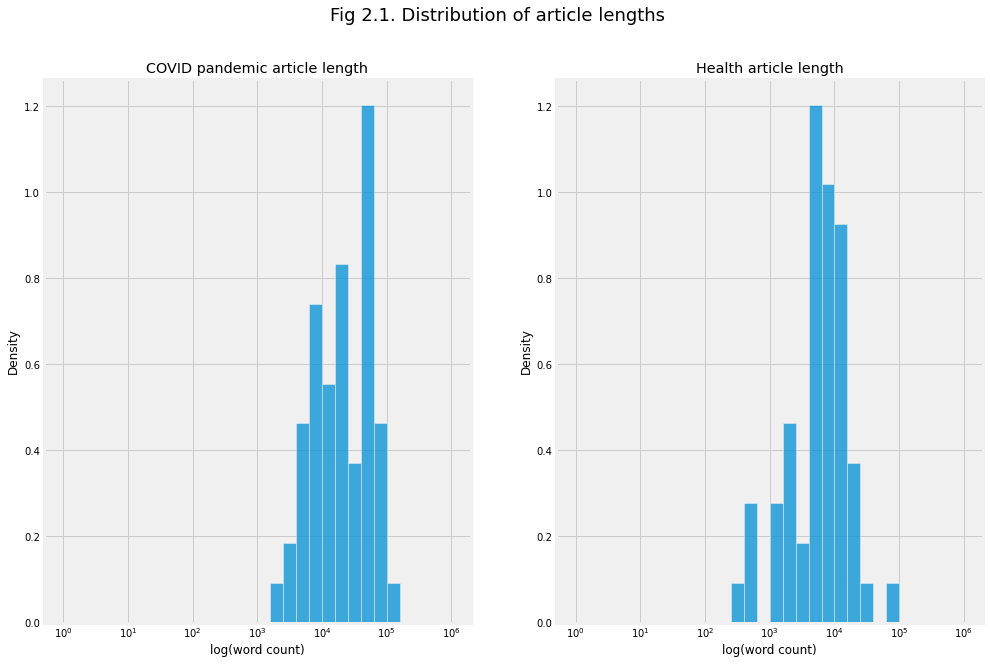

In [25]:
plt.figure(figsize=(15,10))
plt.suptitle('Fig 2.1. Distribution of article lengths', fontsize=18)

ax1 = plt.subplot(121)
sns.histplot(health_wiki_df['wiki_covid_length'], stat='density', binwidth=0.2, binrange=(0, 6), log_scale=True, ax=ax1)
_ = ax1.set(xlabel='log(word count)', ylabel='Density')
_ = plt.title('COVID pandemic article length')

ax2 = plt.subplot(122)
sns.histplot(health_wiki_df['wiki_pub_health_length'], stat='density', binwidth=0.2, binrange=(0, 6), log_scale=True, ax=ax2)
_ = ax2.set(xlabel='log(word count)', ylabel='Density')
_ = plt.title('Health article length')


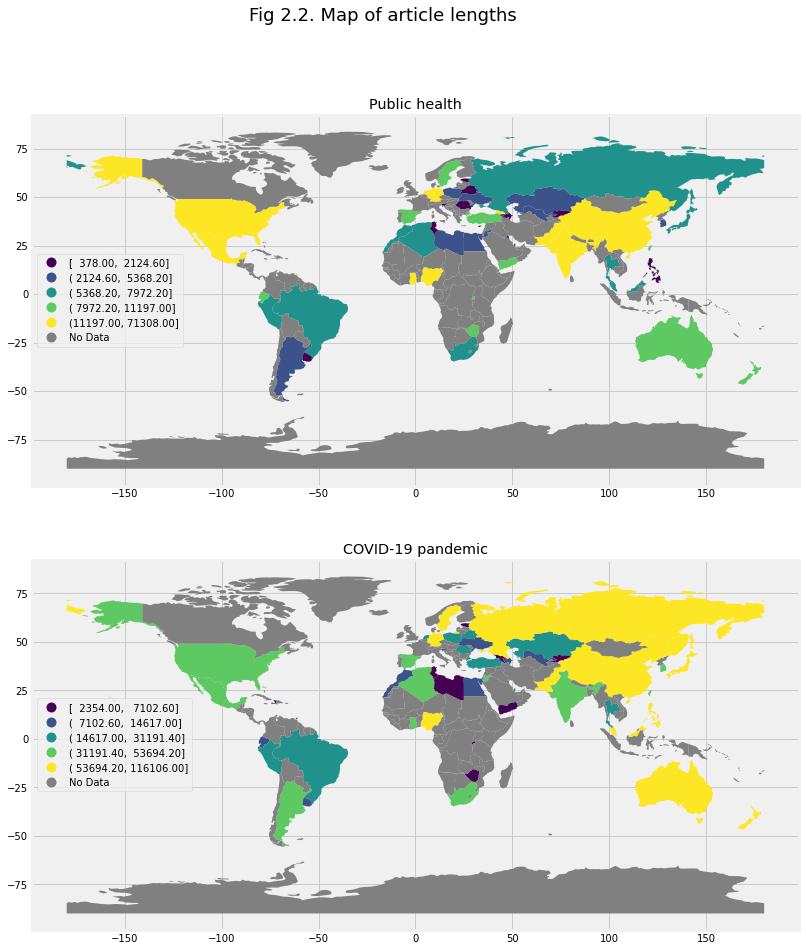

In [26]:
gdf = gpd.GeoDataFrame(pt1.world[['geometry', 'iso_a3']]).set_index('iso_a3').join(health_status[['wiki_pub_health_length', 'wiki_covid_length']], how='left')
plt.figure(figsize=(30, 15))
ax1 = plt.subplot(211)
plt.suptitle('Fig 2.2. Map of article lengths', fontsize=18)

missing_kwds = dict(color='grey', label='No Data')

gdf.plot(column='wiki_pub_health_length', scheme='Quantiles', k= 5,
         legend=True, legend_kwds=dict(loc='center left'),
         missing_kwds=missing_kwds, ax=ax1)

plt.title("Public health")

ax2 = plt.subplot(212)

gdf.plot(column='wiki_covid_length', scheme='Quantiles', k= 5,
         legend=True, legend_kwds=dict(loc='center left'),
         missing_kwds=missing_kwds, ax=ax2)

_ = plt.title("COVID-19 pandemic")

Text(0.5, 1.0, 'Fig 2.3. Spearman rank correlation heatmap between epidemiology, word counts, and WVS')

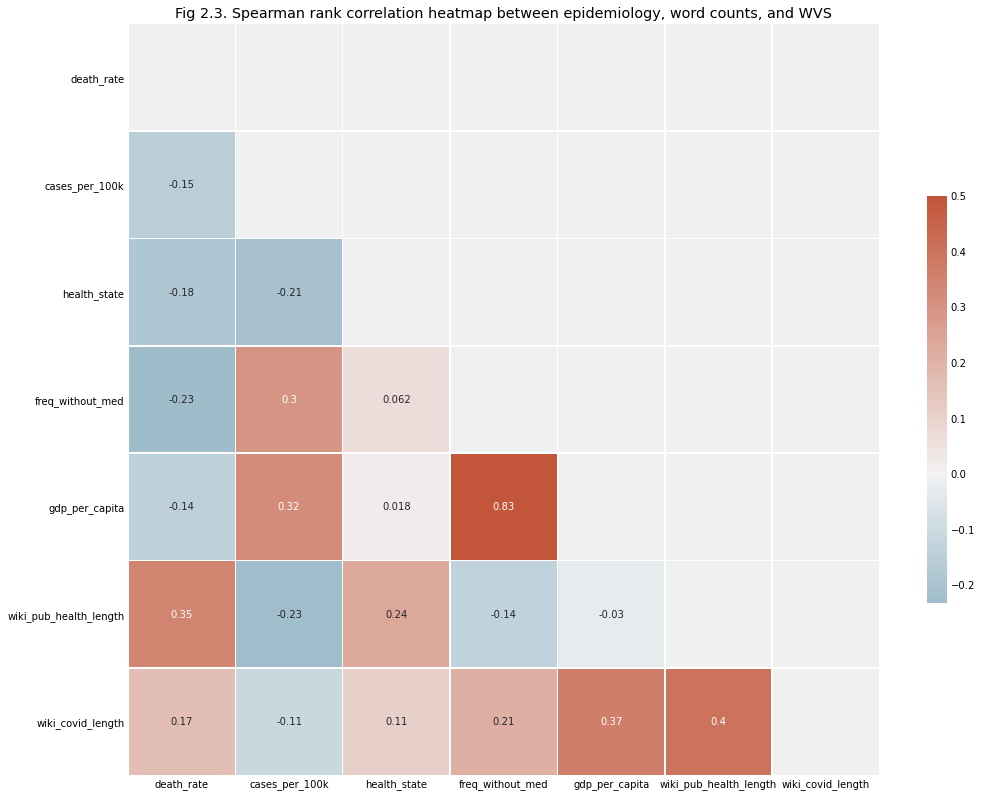

In [27]:

corr = health_wiki_df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("Fig 2.3. Spearman rank correlation heatmap between epidemiology, word counts, and WVS")

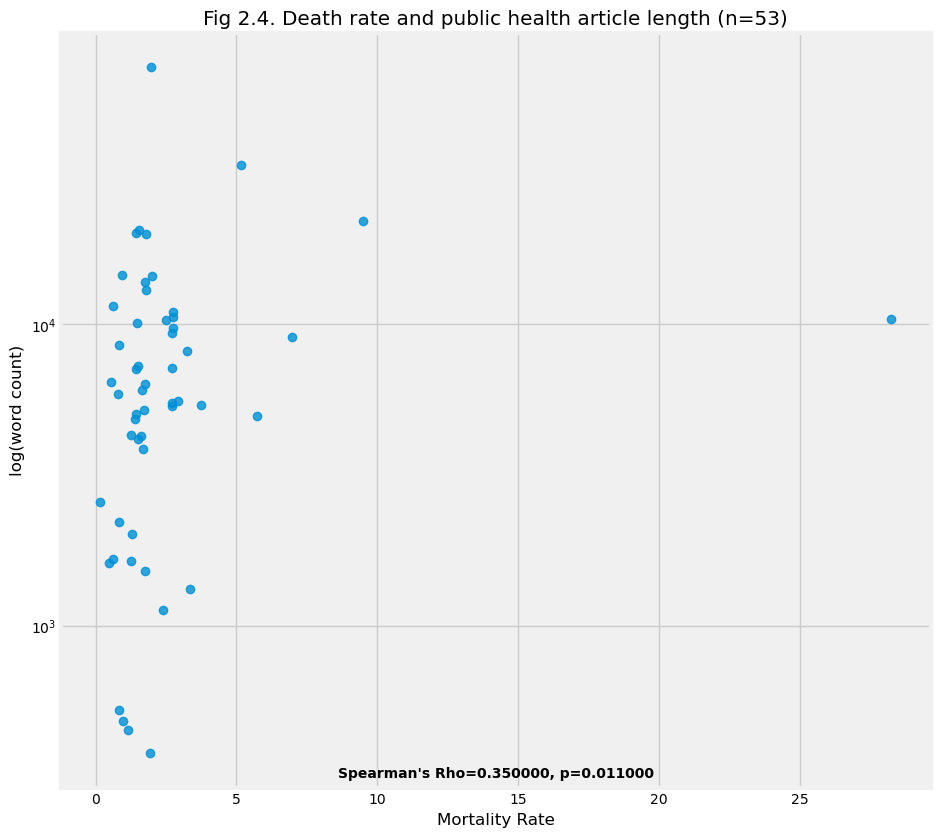

In [28]:
x = 'death_rate'
y = 'wiki_pub_health_length'
x_label = 'Mortality Rate'
y_label = 'log(word count)'
title = 'Fig 2.4. Death rate and public health article length'

spearmanr = stats.spearmanr(health_wiki_df[x], health_wiki_df[y], nan_policy='omit')
r = round(spearmanr[0], 2)
p = round(spearmanr[1], 3)

# annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':10}}

plt.figure(figsize=(10, 10), dpi=100)
ax = sns.regplot(data=health_wiki_df, x=x, y=y, fit_reg=False)
ax.set(yscale='log')
plt.text(0.5,0.01, "Spearman's Rho={:f}, p={:f}".format(r,p),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=ax.transAxes)
_ = ax.set(xlabel=x_label, ylabel=y_label, title= title + f" (n={len(health_wiki_df[[x,y]].dropna())})")
# ax.legend(loc='best', **annot_kws)

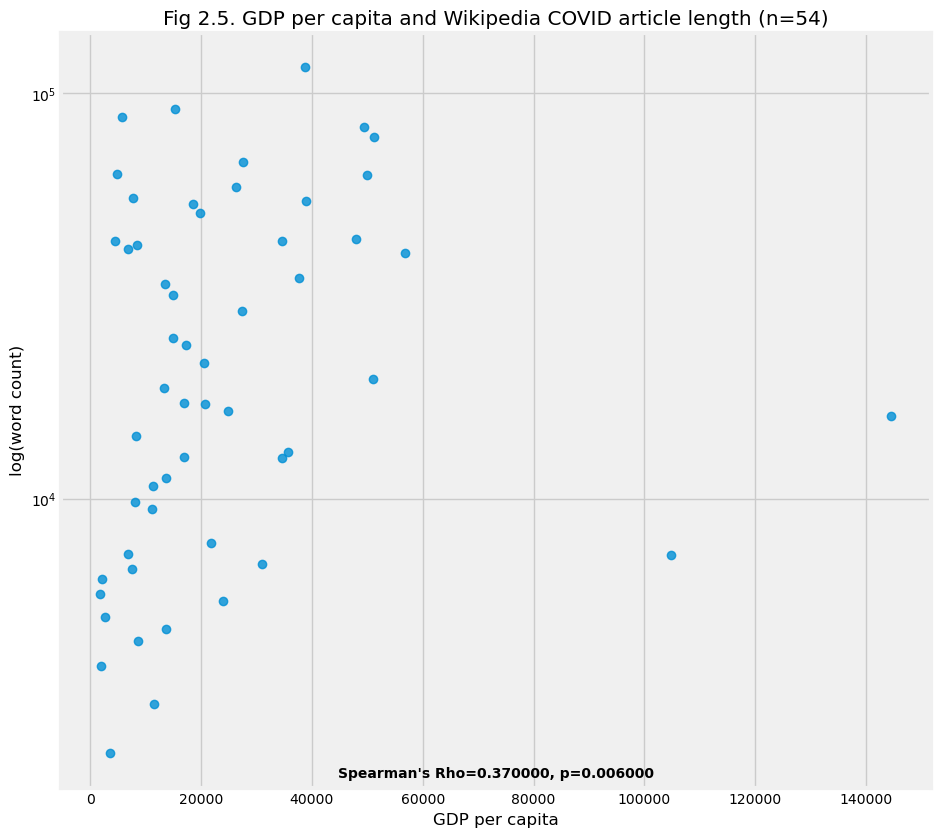

In [29]:
x = 'gdp_per_capita'
y = 'wiki_covid_length'
x_label = 'GDP per capita'
y_label = 'log(word count)'
title = 'Fig 2.5. GDP per capita and Wikipedia COVID article length'

spearmanr = stats.spearmanr(health_wiki_df[x], health_wiki_df[y], nan_policy='omit')
r = round(spearmanr[0], 2)
p = round(spearmanr[1], 3)

plt.figure(figsize=(10, 10), dpi=100)
ax = sns.regplot(data=health_wiki_df, x=x, y=y, fit_reg=False)
ax.set(yscale='log')
plt.text(0.5,0.01, "Spearman's Rho={:f}, p={:f}".format(r,p),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=ax.transAxes)
_ = ax.set(xlabel=x_label, ylabel=y_label, title= title + f" (n={len(health_wiki_df[[x,y]].dropna())})")

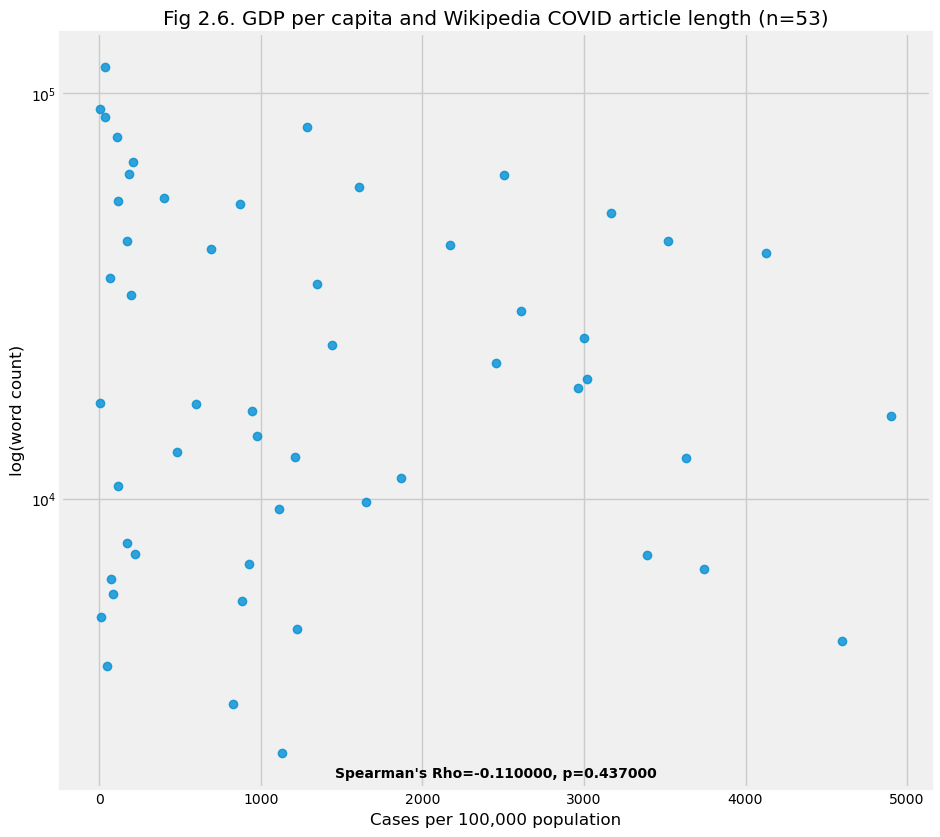

In [30]:
x = 'cases_per_100k'
y = 'wiki_covid_length'
x_label = 'Cases per 100,000 population'
y_label = 'log(word count)'
title = 'Fig 2.6. GDP per capita and Wikipedia COVID article length'

spearmanr = stats.spearmanr(health_wiki_df[x], health_wiki_df[y], nan_policy='omit')
r = round(spearmanr[0], 2)
p = round(spearmanr[1], 3)

plt.figure(figsize=(10, 10), dpi=100)
ax = sns.regplot(data=health_wiki_df, x=x, y=y, fit_reg=False)
ax.set(yscale='log')
plt.text(0.5,0.01, "Spearman's Rho={:f}, p={:f}".format(r,p),
         ha='center', verticalalignment='bottom', fontweight='bold', transform=ax.transAxes)
_ = ax.set(xlabel=x_label, ylabel=y_label, title= title + f" (n={len(health_wiki_df[[x,y]].dropna())})")

## Discussion

The two response variables both distribute with a slight left skew on the log scale which means normal distribution methods cannot be readily applied (Table 2.1). The word count of COVID-19 pandemic articles demonstrated a higher mean and greater variance in comparison to health care articles. The newness of COVID-19 and the significantly higher mean word count raises uncertainties around the quality that these contents represent despite the theoretical groundwork. The large variance shows that there are varying degrees of information available for each country on Wikipedia, but this may reflect the real-world situation as some countries are much more transparent with COVID data. For example, countries, including the UK, have been faced with sporadic COVID update pauses (iTV, 2020; The Guardian, 2020; The New York Times, 2020). Combined with the lack of effective communication channels in some countries, the larger variance is unsurprising.

The geographic concentration of the longest articles is found distributed in developed countries, such as the USA and the UK, as well as developing countries, Nigeria, Mali, and Ethiopia (Fig 2.1). Concentration on developed countries such as the USA and the UK often covers topics such as healthcare reforms which are usually a highly political topic. Topics found in developing nations are often more survivalist and speak to diseases and basic medical access. Of course, this is a high-level generalization, and the division of articles is much more nuanced at a closer scale. For COVID-19 articles, a greater concentration of long articles was found in East Asia, Russia, select European countries, and Australia. These may be a result of the coverage that these nations receive in the media. No identifiable congruency between public health and COVID-19 pandemic article concentrations was observed geographically and this is confirmed by their weak Spearman correlation (Fig 2.2).

The correlation matrix revealed several weakly correlated variables with COVID-19 and public health articles. Public health article length and death rate demonstrated a moderately weak positive monotonic relationship (Spearman’s Rho=0.38, p<0.005). A possible explanation for this relationship is that countries with longer public health articles carry a greater degree of underlying conditions, thus rendering the country more susceptible to COVID-19. The other moderately weak positive correlation is found between GDP per capita and COVID-19 article lengths (Spearman’s Rho=0.37, p<0.005). In general, countries with a higher GDP per capita respectively saw slightly longer articles. This may be a result of wealthier countries having more capable contributors to Wikipedia or a result of having more information available to be aggregated on Wikipedia. Case counts, slightly surprisingly, did not form a statistically significant relationship with either response variables. 

To summarize, public health article length was found to have some statistically significant relationship with the death rate. COVID article length and GDP was also found to have a moderately weak relationship. The logical conclusion for the research questions seems to be Wikipedia articles reflect real-world qualities and events, rather than acting as an input into real-world events. 


# Limitations

There are inherent limitations to the research design of a purely descriptive analysis. Relying solely on descriptive statistics, few concrete conclusions can be drawn compared to analysis with the application of robust inferential statics. Explanations or extrapolations beyond behaviours readily exhibited by the data is likely inappropriate during a descriptive study. However, a descriptive analysis remains a powerful tool and essential steps for understanding the data before more complex analysis is carried out. Put differently, carrying out inferential statics without adequate descriptive analysis may also mislead researchers due to unfamiliarity with the data. 

The data used in this particular study also possesses limitations. The timeframe from which the WVS responses were selected is dated as it included survey results from 11 years ago. The decision to use the data, while grounded in theory, may still possess analytical challenges and reveal spurious behaviours that are not generalizable and scientific. Furthermore, the data from the OxCovid database contained only a subset of the overall WVS questions and with a lack of clear documentation, it is difficult to interpret the selection decisions. 

To fit the analyses carried out within a reasonable theoretical construct, several assumptions were made. Several assumptions are made in this analysis. Within-country homogeneity is assumed by using the country-level aggregate of WVS data, but a country’s values can differ vastly internally. Further, the analyses carried out in this study also did not investigate within sample variances, thus the validity of the included country-level aggregates may be statistically dubious. The use of a summated Likert-score is also a contentious approach within the statistics community (Warmbrod, 2014). A significant assumption of an equal interval is made by assigning a set of continuous values to a set of ordinal values. The use of Spearman’s rank correlation instead of Pearson’s correlation attempts to address this limitation by upholding the non-parametric assumption of the data. 

There also exists a theoretical limitation in part 2 with the use of word count as a proxy of quality and is likely an overly simplified measure. Nonetheless, the question raised between developing a better understanding of the causal relationships of Wikipedia articles and real-life measures is an opportunity for further work. Given the prevalence of Wikipedia in society, I believe there are many undiscovered links between Wikipedia and the off-line society which must be measured through a valid construct and operationalized with an adequate measure. Such a measure will likely require the application of multivariate modelling and more robust inferential models.


# References

BBC. (2020). Coronavirus: The world in lockdown in maps and charts - BBC News. https://www.bbc.co.uk/news/world-52103747

Blumenstock, J. E. (2008). Size matters: Word count as a measure of quality on Wikipedia. Proceeding of the 17th International Conference on World Wide Web 2008, WWW’08. https://doi.org/10.1145/1367497.1367673

Cowling, B. J., Ali, S. T., Ng, T. W. Y., Tsang, T. K., Li, J. C. M., Fong, M. W., Liao, Q., Kwan, M. Y., Lee, S. L., Chiu, S. S., Wu, J. T., Wu, P., & Leung, G. M. (2020). Impact assessment of non-pharmaceutical interventions against coronavirus disease 2019 and influenza in Hong Kong: an observational study. The Lancet Public Health, 5(5), e279–e288. https://doi.org/10.1016/S2468-2667(20)30090-6

Dunn, P., Allen, L., Cameron, G., & Alderwick, H. (2020). COVID-19 policy tracker | The Health Foundation. https://www.health.org.uk/news-and-comment/charts-and-infographics/covid-19-policy-tracker

Hale, T., Angrist, N., Kira, B., Petherick, A., Phillips, T., & Webster, S. (2020). Variation in government responses to COVID-19. www.bsg.ox.ac.uk/covidtracker

Heilman, J. M., & West, A. G. (2015). Wikipedia and medicine: Quantifying readership, editors, and the significance of natural language. Journal of Medical Internet Research, 17(3), e62. https://doi.org/10.2196/jmir.4069

Inglehart, R. (1977). Stability and Change in Value Priorities. In The Silent Revolution: Changing Values and Political Styles Among Western Publics (pp. 99–115). Princeton University Press. https://doi.org/10.2307/j.ctt13x18ck.8

Inglehart, R., & Welzel, C. (2020). Inglehart–Welzel cultural map. http://www.worldvaluessurvey.org/WVSContents.jsp?CMSID=Findings

iTV. (2020). Publication of UK daily coronavirus death figures put on “pause” as Matt Hancock calls for review into PHE data | ITV News. https://www.itv.com/news/2020-07-18/publication-of-daily-coronavirus-death-figures-put-on-pause-as-matt-hancock-calls-for-review-into-phe-data

McIver, D. J., & Brownstein, J. S. (2014). Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time. PLoS Computational Biology, 10(4), e1003581. https://doi.org/10.1371/journal.pcbi.1003581

Minkov, M., & Hofstede, G. (2012). Is National Culture a Meaningful Concept? Cross-Cultural Research, 46(2), 133–159. https://doi.org/10.1177/1069397111427262

O’Leary, D. E., & Storey, V. C. (2020). A Google–Wikipedia–Twitter Model as a Leading Indicator of the Numbers of Coronavirus Deaths. Intelligent Systems in Accounting, Finance and Management, 27(3), 151–158. https://doi.org/10.1002/isaf.1482

Priedhorsky, R., Osthus, D., Daughton, A. R., Moran, K. R., Generous, N., Fairchild, G., Deshpande, A., & del Valle, S. Y. (2017). Measuring global disease with Wikipedia: Success, failure, and a research agenda. Proceedings of the ACM Conference on Computer Supported Cooperative Work, CSCW, 2017, 1812–1834. https://doi.org/10.1145/2998181.2998183

Reeskens, T., Muis, Q., Sieben, I., Vandecasteele, L., Luijkx, R., & Halman, L. (2020). Stability or change of public opinion and values during the coronavirus crisis? Exploring Dutch longitudinal panel data. European Societies, 1–19. https://doi.org/10.1080/14616696.2020.1821075

Salganik, M. J. (2017). Bit by Bit: Social Research in the Digital Age (Open review edition). Princeton University Press.

Smith, D. A. (2020). Situating Wikipedia as a health information resource in various contexts: A scoping review. PLOS ONE, 15(2), e0228786. https://doi.org/10.1371/journal.pone.0228786
Thacher, D., & Rein, M. (2004). Managing Value Conflict in Public Policy. Governance, 17(4), 457–486. https://doi.org/10.1111/j.0952-1895.2004.00254.x

The Guardian. (2020). Brazil stops releasing Covid-19 death toll and wipes data from official site | World news | The Guardian. https://www.theguardian.com/world/2020/jun/07/brazil-stops-releasing-covid-19-death-toll-and-wipes-data-from-official-site

The New York Times. (2020). Trump Administration Strips C.D.C. of Control of Coronavirus Data - The New York Times. https://www.nytimes.com/2020/07/14/us/politics/trump-cdc-coronavirus.html
Uslaner, E. M. (2002). The stability of trust. In The moral foundations of trust. Cambridge University Press.

Warmbrod, J. R. (2014). Reporting and Interpreting Scores Derived from Likert-type Scales. Journal of Agricultural Education, 55(5). https://doi.org/10.5032/jae.2014.05030
 
